In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# General data organization

In [2]:
df = pd.read_csv('student_responses.csv', keep_default_na=False)

# rename column headers as question numbers
df.columns = ['timestamp', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14']

# insert column for respondent ID
# necessary in case future data wrangling reorders rows
df.insert(0, 'ID', df.index, False)

Each respondent's unique identifier is the corresponding row's index.

---

# General responses

**KEY**  
`*` Required question  
`**` Required question for graduating senior

## Question 1
> What course are you completing this survey for? (Please write the course identifier only, e.g. BSCI100).*

Standardize course codes:
1. Define a [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) function, which will be used to resolve discrepancies between courses that took the survey and responses that indicate courses that are not included (i.e., likely typos). This particular function is copied from [_Geeks for Geeks_' "Introduction to Levenshtein distance" article](https://www.geeksforgeeks.org/introduction-to-levenshtein-distance/).

In [3]:
# Calculates Levenshtein distance (i.e., the smallest number of alterations necessary to turn one word into another).
def levenshtein(a, b):
    len_a = len(a)
    len_b = len(b)
    
    # populate len_a x len_b matrix with 0s
    matrix = [[0 for _ in range(len_b + 1)] for _ in range(len_a + 1)]

    # populate first column of matrix with numbers starting from 0 in first row to len_a in last row...
    for i in range(len_a + 1):
        matrix[i][0] = i
    # ...and first row of matrix with numbers starting from 0 in first column to len_b in last column
    for j in range(len_b + 1):
        matrix[0][j] = j

    # populate matrix with computed edit distances
    for i in range(1, len_a + 1):
        for j in range(1, len_b + 1):
            if a[i - 1] == b[j - 1]:    # characters match
                matrix[i][j] = matrix[i - 1][j - 1]
            else:
                # minimum cost of insertion, deletion, or substitution
                matrix[i][j] = 1 + min(matrix[i][j - 1], matrix[i - 1][j], matrix[i - 1][j - 1])

    # return edit distance between a and b
    return matrix[len_a][len_b]

2. Enforce a course code standard and resolve discrepancies in responses using the previously-defined Levenshtein distance function. The course code standard is as follows:
   1. 4 uppercase letters denoting subject (e.g., "BSCI" or "BIOL") followed by
   2. 3 digits and (optionally) a single uppercase letter denoting course number (e.g., "330" or "708W").

In [4]:
# regexes to look for
subject_pattern = re.compile('[A-Za-z]{4}')         # e.g., "BSCI" or "BIOL"
number_pattern = re.compile('[0-9]{3}[A-Za-z]?')    # e.g., "330" or "708W"

# dictionary of courses recorded in survey
course_list = {('BSCI', '330'): 'Cell Biology and Physiology',
               ('BSCI', '171'): 'Principles of Molecular & Cellular Biology Laboratory',
               ('BSCI', '161'): 'Principles of Ecology and Evolution Lab',
               ('BSCI', '403'): 'Biology of Vision',
               ('BSCI', '462'): 'Population Ecology',
               ('BSCI', '410'): 'Molecular Genetics',
               ('BSCI', '170'): 'Principles of Molecular & Cellular Biology',
               ('BSCI', '401'): 'Animal Communication',
               ('BIOL', '708W'): 'Animal Communication',
               ('BIOE', '241'): 'Biocomputational Methods'}

3. Separate ambiguous responses into subject and number, then compare the Levenshtein distance of each against possible courses' subjects and numbers. Based on the comparison, modify the subject, number, or both.

In [5]:
# iterate through each response in "q1" column and standardize course codes + resolve discrepancies
for i in range(len(df['q1'])):
    subject = subject_pattern.search(df['q1'][i]).group().upper() if subject_pattern.search(df['q1'][i]) else ''
    number = number_pattern.search(df['q1'][i]).group().upper() if number_pattern.search(df['q1'][i]) else ''

    # standardize course code (e.g., biol708w -> BIOL708W) and resolve discrepancies
    if len(number) == 0:    # only "BSCI" -- i.e., ambiguous course code
        df.at[i, 'q1'] = subject + '\n(ambiguous)'
    else:
        df.at[i, 'q1'] = subject + number

        # needs to be modified based on Levenshtein distance
        if (subject, number) not in course_list:
            min_sub_dist = len(subject)
            min_num_dist = len(number)

            # find key with smallest Levenshtein distance from course code
            for (s, n) in course_list:
                sub_dist = levenshtein(s, subject)
                num_dist = levenshtein(n, number)

                # modify subject, number, or both (in case of tie, first minimum selected)
                if sub_dist < min_sub_dist and num_dist == 0:               # only subject different
                    min_sub_dist = sub_dist
                    df.at[i, 'q1'] = s + number
                elif sub_dist == 0 and num_dist < min_num_dist:             # only number different
                    min_num_dist = num_dist
                    df.at[i, 'q1'] = subject + n
                elif sub_dist < min_sub_dist and num_dist < min_num_dist:   # both subject + number different
                    min_sub_dist = sub_dist
                    min_num_dist = num_dist
                    df.at[i, 'q1'] = s + n

Generate bar chart of course data:
- Define a function to display y-values, which displays y-values and their corresponding percentages above each bar.

In [6]:
# Displays y-values.
def ydisplay(x, y, total, onlynum):
    for i in range(len(x)):
        value = y.iloc[i]
        percent = (value / total) * 100

        # display count and percent of each bar above each bar
        if onlynum: # only numerical x-axis labels
            # offset positioning by 1 to the right
            plt.text(i + 1, value, str(value) + ' ({:.1f}%)'.format(percent), ha='center', va='bottom')
        else:
            plt.text(i, value, str(value) + ' ({:.1f}%)'.format(percent), ha='center', va='bottom')

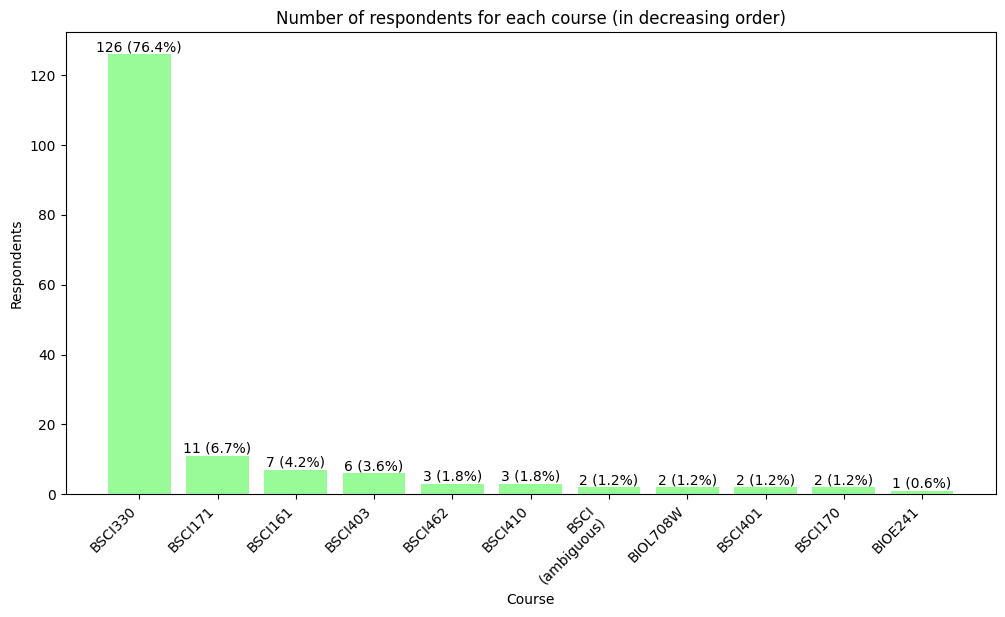

In [7]:
q1_counts = df['q1'].value_counts()     # y-values -- number of respondents
q1_courses = q1_counts.index.tolist()   # x-values -- courses
q1_sum = sum(q1_counts)                 # total number of respondents

# generate bar chart
plt.figure(figsize=(12, 6))
plt.bar(q1_courses, q1_counts, color='palegreen')

# add labels
plt.title('Number of respondents for each course (in decreasing order)')
plt.xlabel('Course')
plt.ylabel('Respondents')
plt.xticks(rotation=45, ha='right')

ydisplay(q1_courses, q1_counts, q1_sum, onlynum=False)
plt.show()

---

## Question 4
> How much time have you spent completing computational biology coursework in all of your BSCI classes up to this point (include in-class and out-of-class time)?*

Generate bar chart of time spent data:

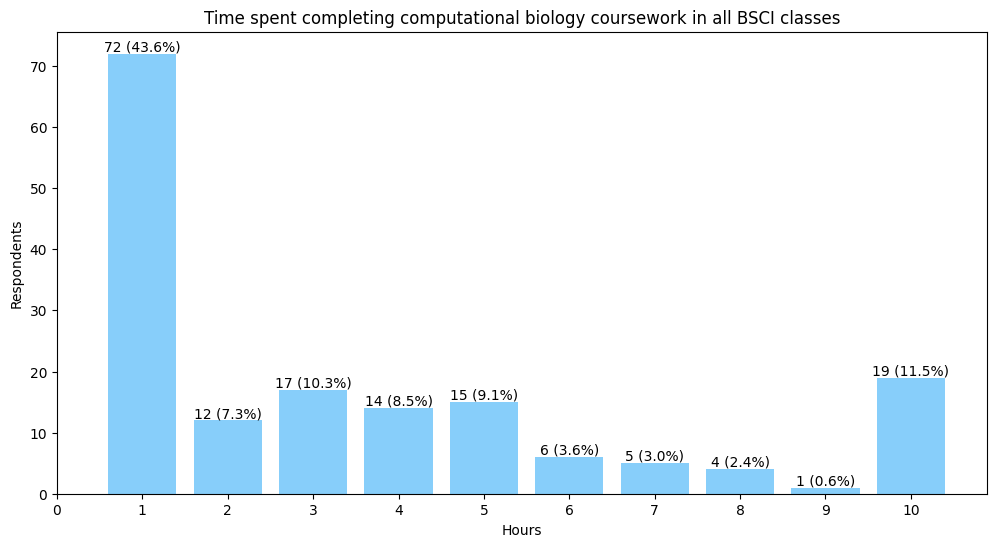

In [8]:
q4_counts = df['q4'].value_counts().sort_index()    # y-values -- number of respondents
q4_times = q4_counts.index.tolist()                 # x-values -- hours
q4_sum = sum(q4_counts)                             # total number of respondents

# generate bar chart
plt.figure(figsize=(12, 6))
plt.bar(q4_times, q4_counts, color='lightskyblue')

# add labels
plt.title('Time spent completing computational biology coursework in all BSCI classes')
plt.xticks(range(11))   # add ticks for 1-10 hours (inclusive)
plt.xlabel('Hours')
plt.ylabel('Respondents')

ydisplay(q4_times, q4_counts, q4_sum, onlynum=True)
plt.show()

---

## Question 10
> Are you graduating this semester (Spring 2024)?*

Generate bar chart of graduation data:

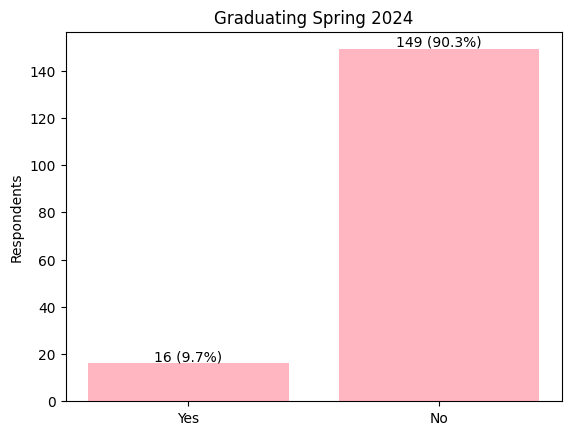

In [9]:
q10_counts = df['q10'].value_counts(sort=False) # y-values -- number of respondents
q10_ans = q10_counts.index.tolist()             # x-values -- answers
q10_sum = sum(q10_counts)                       # total number of respondents

# generate bar chart
plt.bar(q10_ans, q10_counts, color='lightpink')
plt.title('Graduating Spring 2024')
plt.ylabel('Respondents')

ydisplay(q10_ans, q10_counts, q10_sum, onlynum=False)
plt.show()

---

## Question 11
> Did your overall education at UMD (including outside of BSCI) in computational biology influence your ability to apply for or receive a job you wanted?**

After dropping responses not from seniors, generate bar chart of job application/acceptance data amongst seniors:

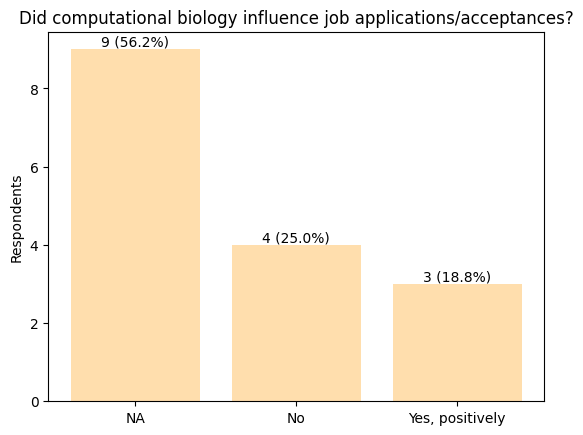

In [10]:
q11_counts = df['q11'].value_counts(dropna=False)   # y-values -- number of respondents
q11_counts.drop(labels='', inplace=True)            # drop empty responses (i.e., non-senior responses)
q11_ans = q11_counts.index.tolist()                 # x-values -- answers
q11_sum = sum(q11_counts)                           # total number of respondents

# generate bar chart
plt.bar(q11_ans, q11_counts, color='navajowhite')
plt.title('Did computational biology influence job applications/acceptances?')
plt.ylabel('Respondents')

ydisplay(q11_ans, q11_counts, q11_sum, onlynum=False)
plt.show()

---

# Responses by class
## BSCI330
### Question 1


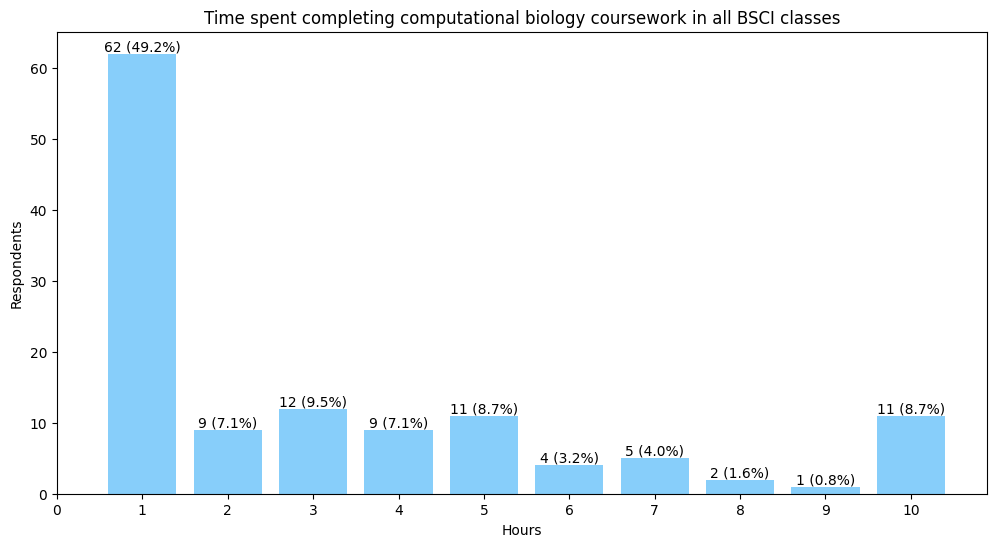

In [18]:
bsci330 = df[df.q1 == 'BSCI330']

def question4(course):
    counts = course.value_counts().sort_index()
    times = counts.index.tolist()
    total = sum(counts)

    plt.figure(figsize=(12, 6))
    plt.bar(times, counts, color='lightskyblue')

    plt.title('Time spent completing computational biology coursework in all BSCI classes')
    plt.xticks(range(11))
    plt.xlabel('Hours')
    plt.ylabel('Respondents')

    ydisplay(times, counts, total, onlynum=True)
    plt.show()

question4(bsci330['q4'])